In [3]:
import sys
import pandas as pd
from load_data import get_data, load_pkl, save_pkl
from processing_helpers import get_cue_segments, get_power_spec, get_peak_fits, get_control_segments
import pickle as pkl
import numpy as np
import os
import matplotlib.pyplot as plt
from fooof import FOOOF
from scipy.stats import sem, f_oneway, ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
import analysis_helpers as ah
import seaborn as sns

%matplotlib inline


In [4]:
# Global variables to store the session data
lfp_df = pd.DataFrame()
ch_num_list = []
lfp_mne = []
session_start_time = 0
markers = []
timeStamps = []
sampling_frequency = 0
cue_segments_df = pd.DataFrame()
control_segments_df = pd.DataFrame()

theta_range = [3, 12]

In [6]:
def load_data(day):
    """
    Load LFP data for a given day.
    """
    global lfp_df, ch_num_list, lfp_mne, session_start_time, markers, timeStamps, sampling_frequency
    print(f"Loading data for {day}...")
    lfp_df, ch_num_list, lfp_mne, session_start_time, markers, timeStamps, sampling_frequency = get_data(day)

    if lfp_df is not None:
        print(f"Loaded {len(ch_num_list)} channels.")
        print(lfp_df.head())
    else:
        print("Failed to load data.")

def compute_theta_trials(data, key='flat_spec_og'):
    """
    For each trial in the DataFrame, compute the sum of power in the theta band (3-12 Hz).
    """
    if data.empty:
        return []
    psd_list = data[key].tolist()
    lengths = [arr.shape[0] for arr in psd_list if hasattr(arr, 'shape')]
    if not lengths:
        return []
    min_length = min(lengths)
    # Compute the theta power by summing values in indices corresponding to theta_range
    trial_values = [np.sum(psd[:min_length][theta_range[0]:theta_range[1]]) for psd in psd_list]
    return trial_values


In [12]:
cue_segments_df['channel']

0        009
1        019
2        021
3        022
4        023
        ... 
10369    089
10370    092
10371    093
10372    119
10373    120
Name: channel, Length: 10374, dtype: object

In [16]:
# Load Raw Data
day = "20181105"
load_data(day)

# Extract segments with a specific window size and process
window_size = 1000  # e.g., 1000 ms
peak_fit_range = [1,14]

interesting_ch = {
    '20181102' : [9,19,26,29,30,31,43,45],
    '20181105' : [19,23,29,30,43,45],
    '20181101' : [19,21,23,29,30,35,43,45],
    '20181031' : [19,26,29,30,35,43,45],
    '20181026' : [19,29,30,35,45],
    '20181022' : [9,17,26,29,43,45]
}

cue_segments_df = load_pkl(f"/Users/liuyuanwei/Desktop/Data Processed/{day}/{day}_cue.pkl")
control_segments_df = load_pkl(f"/Users/liuyuanwei/Desktop/Data Processed/{day}/{day}_control.pkl")

channel_no = sorted(cue_segments_df['channel'].unique())
ch_indx = channel_no
# ch_indx = []
# for i in interesting_ch:
#     ch_str = f"{i:03}"
#     if ch_str in channel_no:
#         ch_indx.append(channel_no.index(ch_str))

# --- Preprocess: Convert channel values to zero-padded strings ---
cue_segments_df['channel'] = cue_segments_df['channel'].apply(lambda x: f"{int(x):03}")
control_segments_df['channel'] = control_segments_df['channel'].apply(lambda x: f"{int(x):03}")


Loading data for 20181105...
Creating RawArray with float64 data, n_channels=26, n_times=5496020
    Range : 0 ... 5496019 =      0.000 ...  5496.019 secs
Ready.
Loaded 26 channels.
  channel                                           lfp_data
0     009  [-15.689277, -63.415035, -97.32542, -110.48099...
1     019  [-7.3521805, -22.254305, -32.18146, -35.23267,...
2     021  [-7.631544, -1.5259957, 3.660045, 8.1869755, 1...
3     022  [-56.752617, -77.27964, -92.39461, -100.60819,...
4     023  [32.315643, 41.446926, 46.777287, 46.48198, 41...
Data successfully loaded from /Users/liuyuanwei/Desktop/Data Processed/20181105/20181105_cue.pkl
Loaded data has 10374 rows and 14 columns.
                                             segment channel start_position  \
0  [-4.5271883, -1.9674453, 9.442836, 25.153576, ...     009             34   
1  [-42.301697, -45.33196, -43.950962, -39.873737...     019             34   
2  [-76.19089, -30.659563, 20.823097, 73.89416, 1...     021             34

In [22]:
start_positions = sorted(cue_segments_df['start_position'].unique())


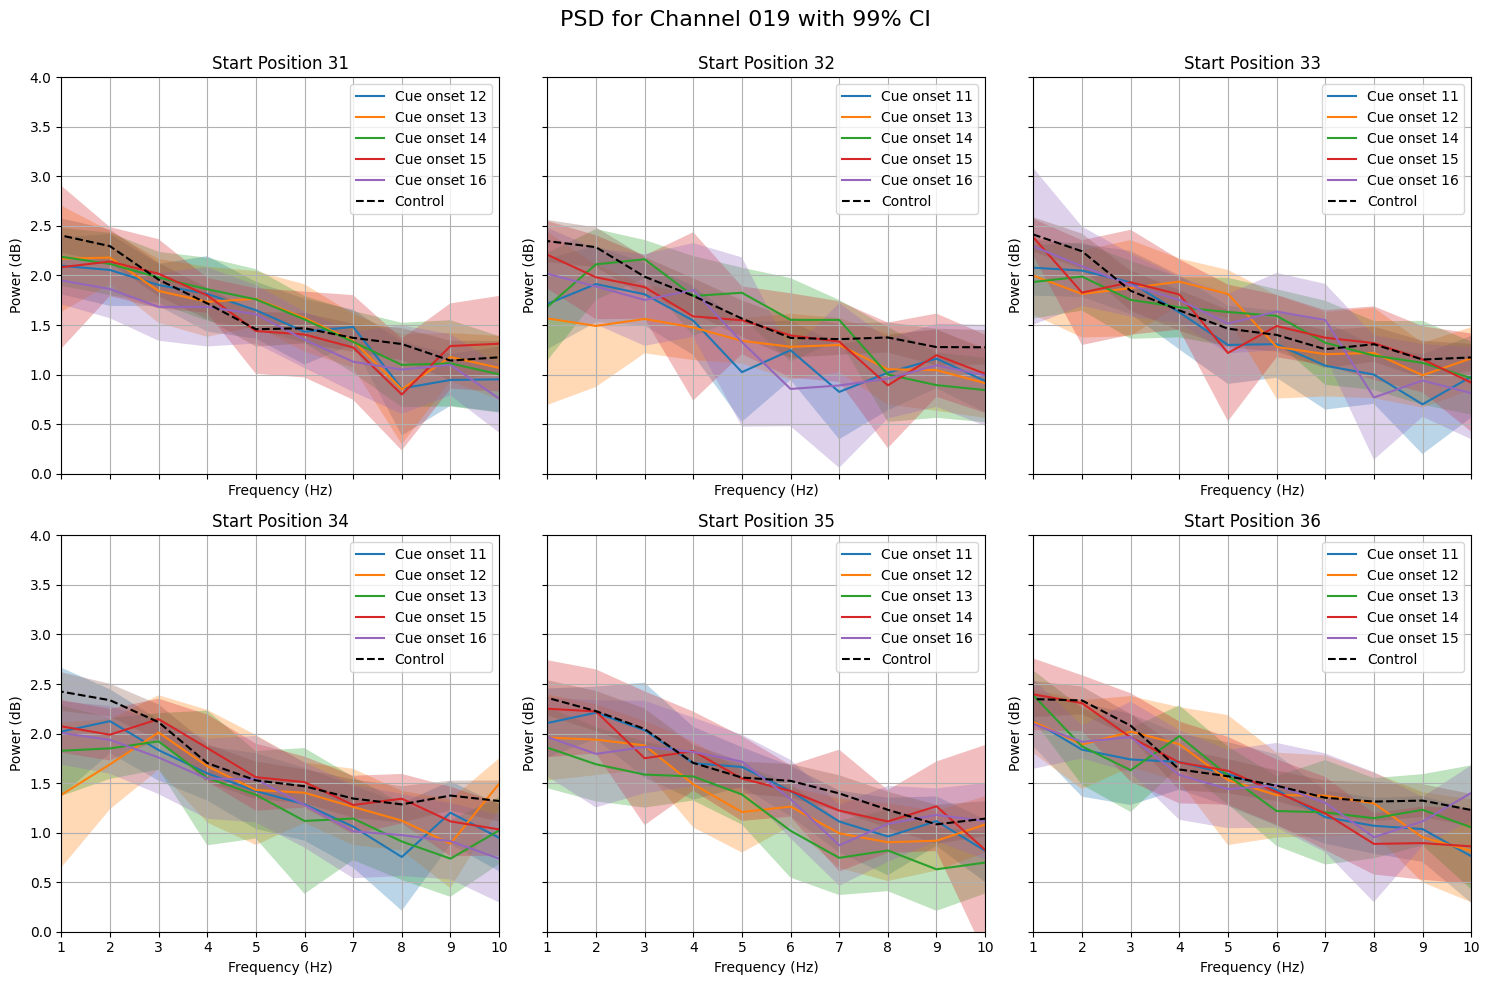

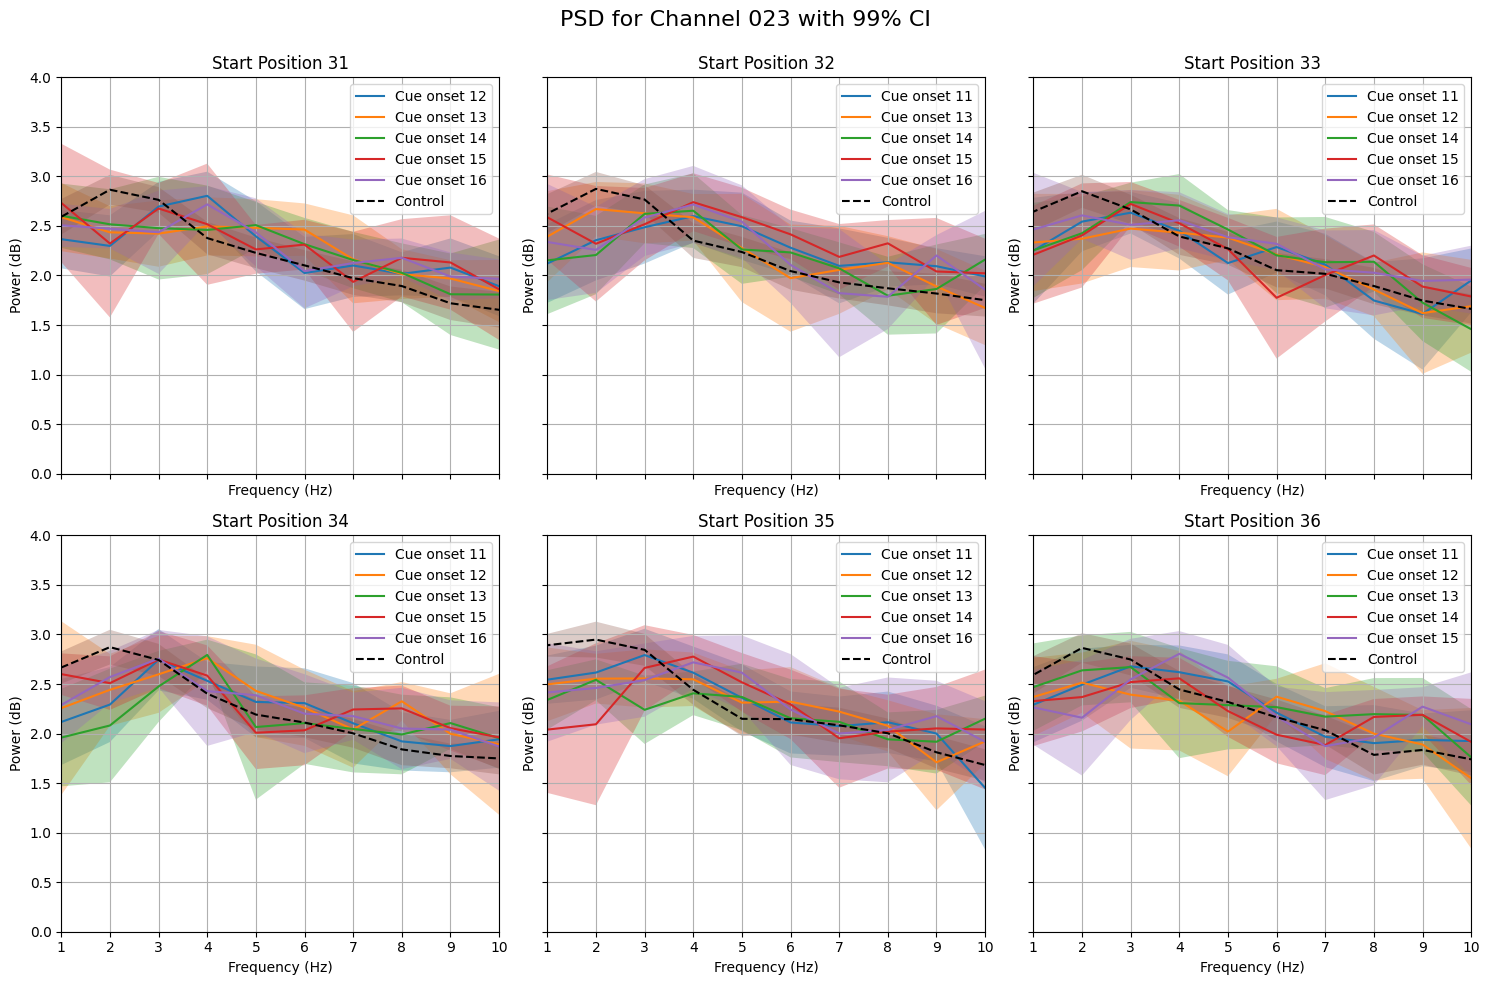

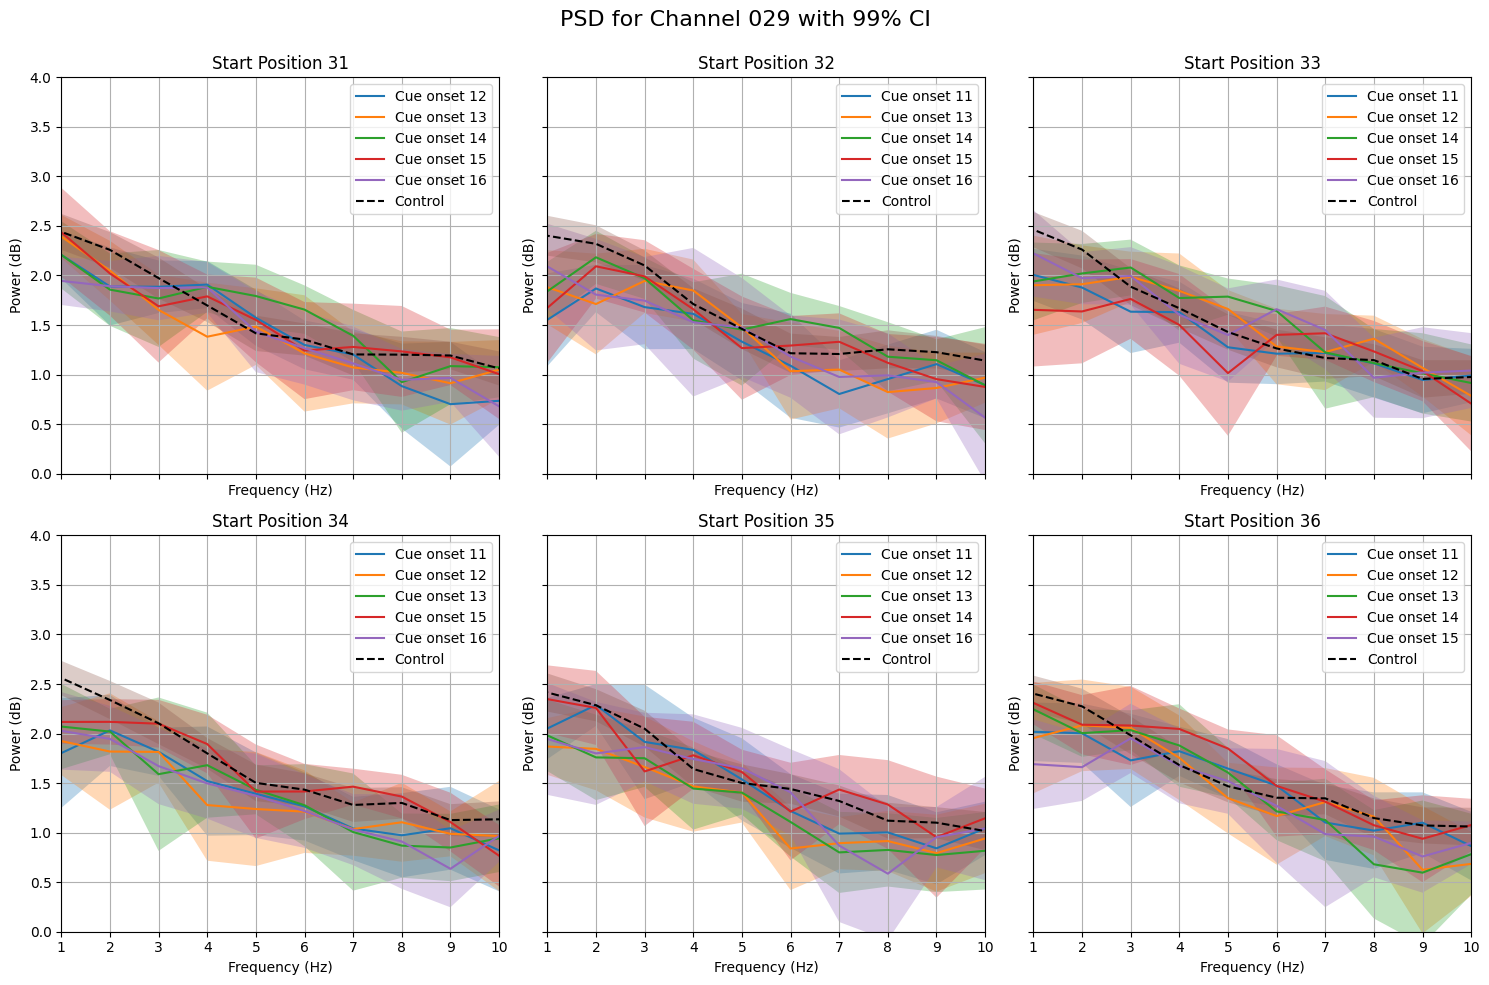

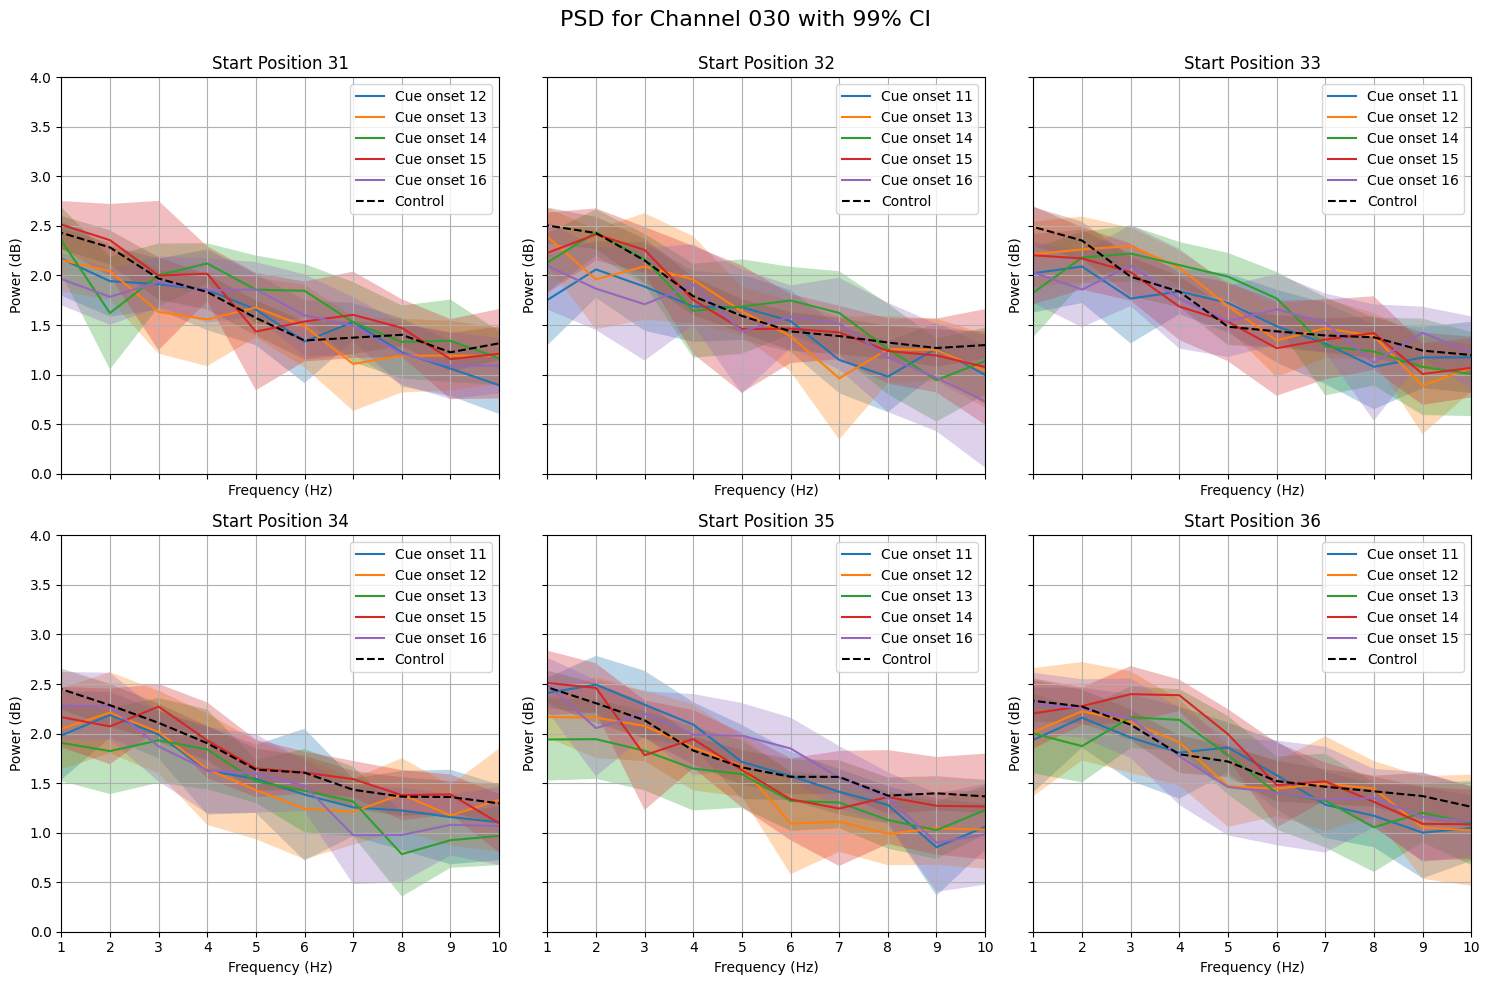

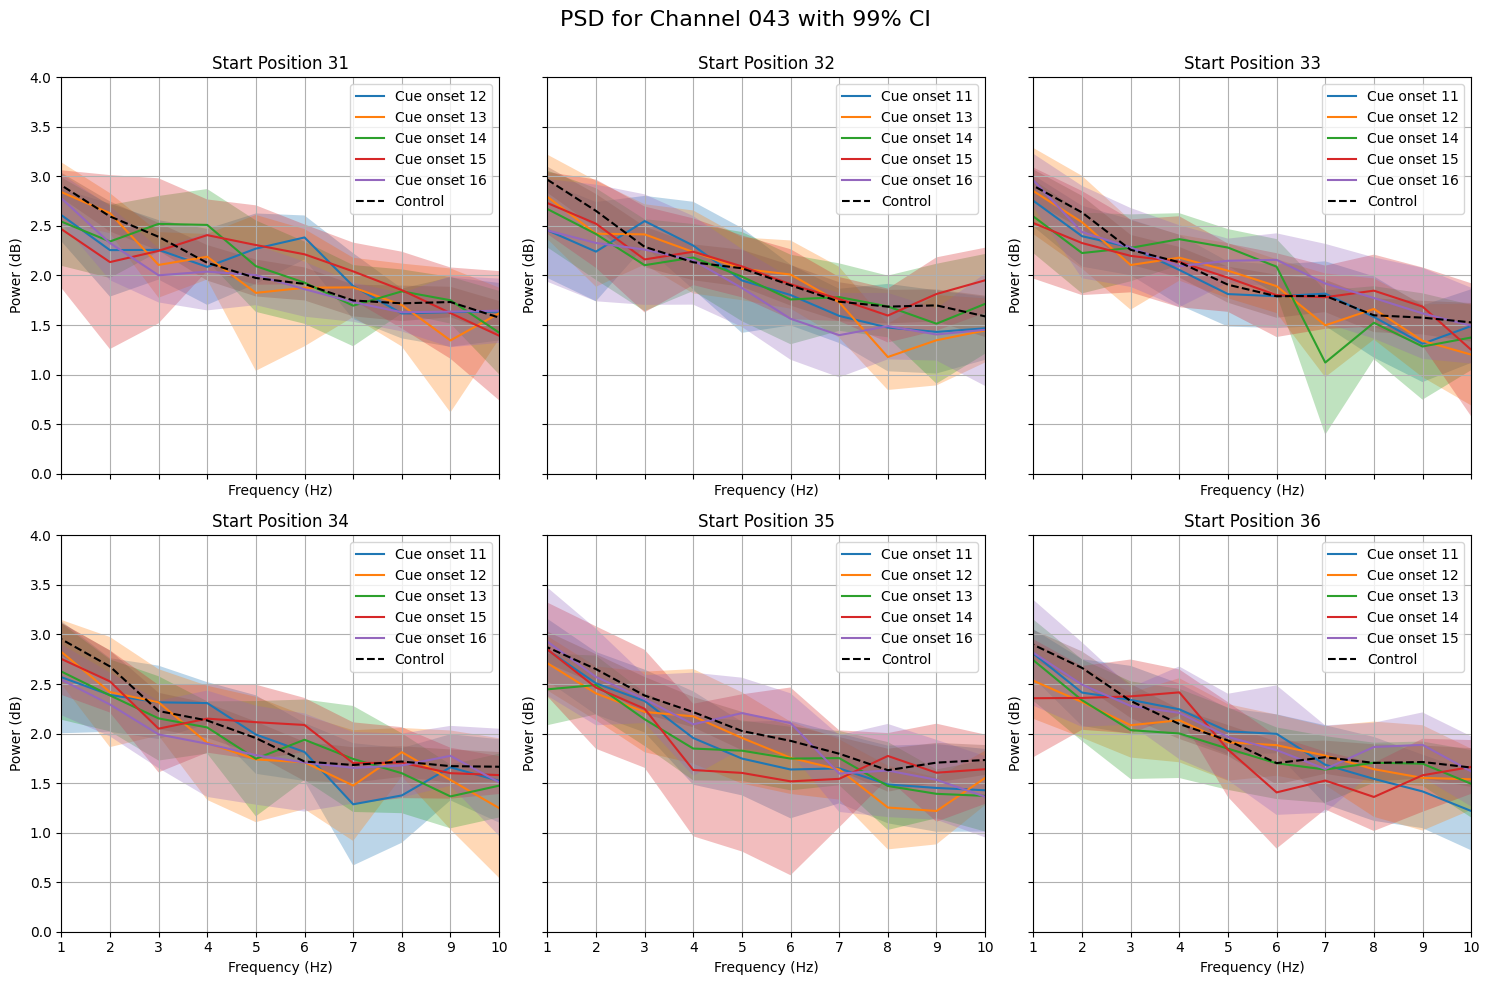

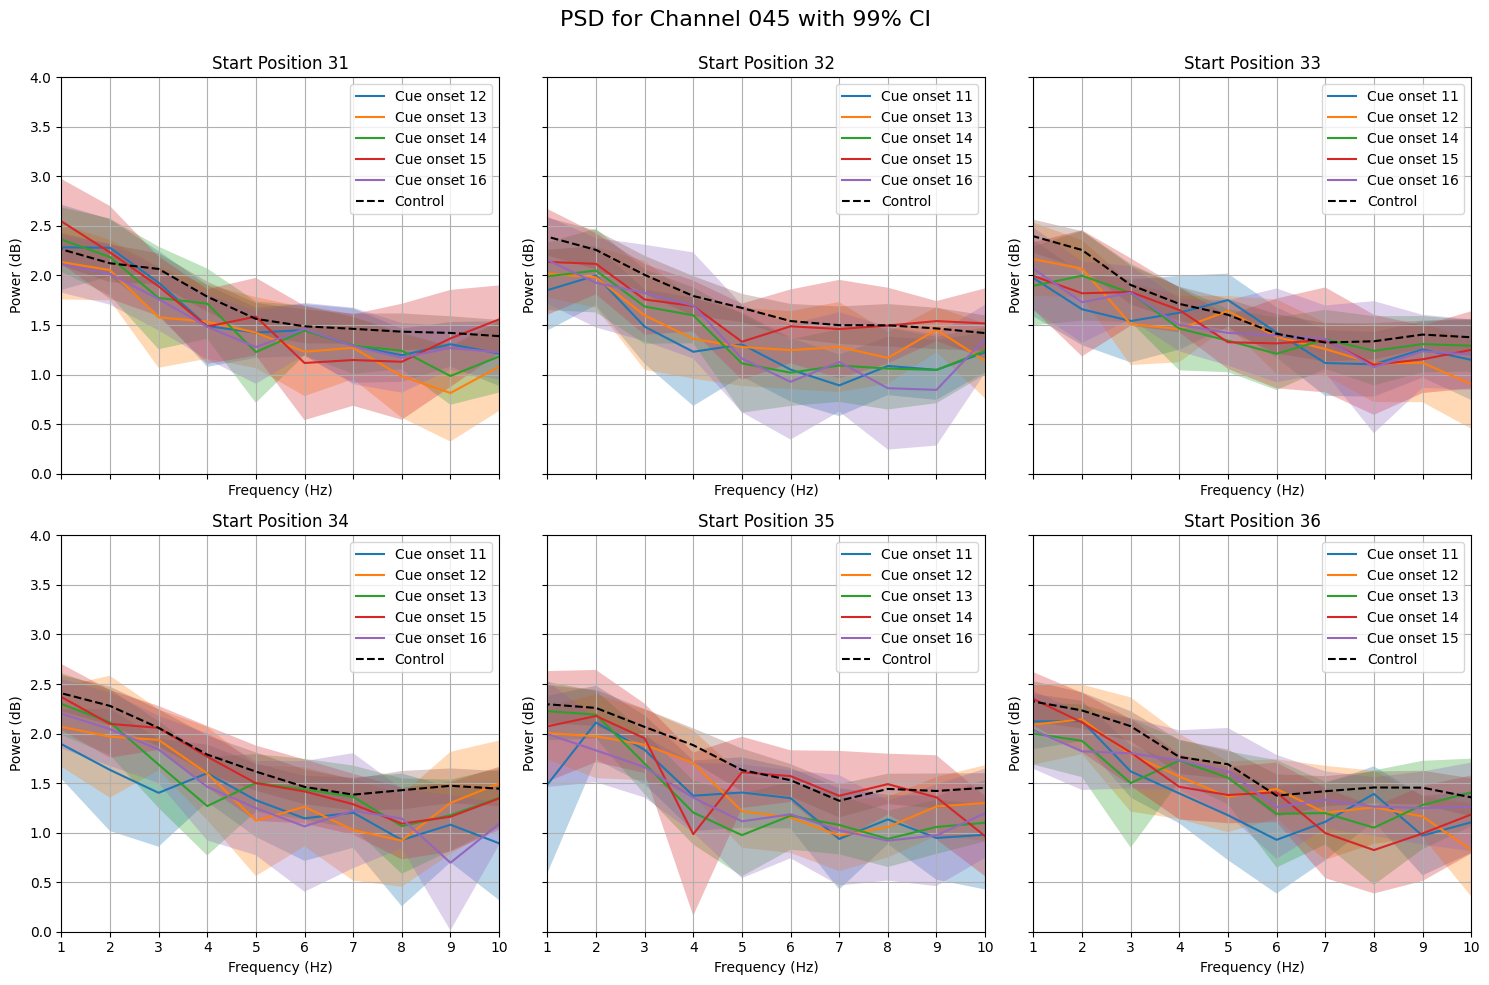

In [66]:
# Create a sorted list of unique channel numbers from your cue data
channel_no = sorted(cue_segments_df['channel'].unique())

# Get indices of channels from channel_no that match the interesting channels for the given day
ch_indx = []
for i in interesting_ch[day]:
    ch_str = f"{i:03}"
    if ch_str in channel_no:
        ch_indx.append(channel_no.index(ch_str))

# --- Helper function to compute mean, SEM, and frequency vector from PSD arrays ---
def process_psd_arrays(data, key='psd'):
    psd_list = data[key].values
    if len(psd_list) == 0:
        return None, None, None
    # Determine the minimum length among arrays to allow stacking
    lengths = [arr.shape[0] for arr in psd_list if hasattr(arr, 'shape')]
    if not lengths:
        return None, None, None
    min_length = min(lengths)
    # Trim each array to the minimum length and stack them
    psd_stack = np.stack([arr[:min_length] for arr in psd_list])
    mean_val = psd_stack.mean(axis=0)
    sem_val = sem(psd_stack, axis=0)
    # Get the frequency vector from the first row (assumed identical across rows)
    freq = data.iloc[0]['freq'][:min_length]
    return mean_val, sem_val, freq

# --- Get unique start positions (assumed to be 6) ---
start_positions = sorted(cue_segments_df['start_position'].unique())

# --- Plotting loop: For each interesting channel, create a figure with 6 subplots ---
for ch in ch_indx:
    # Use the channel string from channel_no for filtering and display
    channel_str = channel_no[ch]
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, start in enumerate(start_positions):
        ax = axes[i]

        # --- Plot Cue Data: One curve per cue onset ---
        cue_data = cue_segments_df[(cue_segments_df['channel'] == channel_str) &
                                   (cue_segments_df['start_position'] == start)]
        if not cue_data.empty and 'cue_onset' in cue_data.columns:
            for onset in sorted(cue_data['cue_onset'].unique()):
                data_onset = cue_data[cue_data['cue_onset'] == onset]
                mean_psd, sem_psd, freq = process_psd_arrays(data_onset, key='psd')
                if mean_psd is not None:
                    ci = 2.576 * sem_psd  # 99% Confidence Interval
                    ax.plot(freq, mean_psd, '-', label=f'Cue onset {onset}')
                    ax.fill_between(freq, mean_psd - ci, mean_psd + ci, alpha=0.3)

        # --- Plot Control Data: Aggregate over all entries (ignoring onset) ---
        control_data = control_segments_df[(control_segments_df['channel'] == channel_str) &
                                           (control_segments_df['start_position'] == start)]
        if not control_data.empty:
            mean_psd, sem_psd, freq = process_psd_arrays(control_data, key='psd')
            if mean_psd is not None:
                ci = 2.576 * sem_psd  # 99% Confidence Interval
                ax.plot(freq, mean_psd, '--', label='Control', color='black')
                ax.fill_between(freq, mean_psd - ci, mean_psd + ci, alpha=0.3)

        # Customize the subplot
        ax.set_title(f'Start Position {start}')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Power (dB)')
        ax.set_xlim([1, 10])
        ax.set_ylim([0, 4])
        ax.legend(loc='upper right')
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle(f'PSD for Channel {channel_str} with 99% CI', fontsize=16)
    plt.show()


In [28]:
import os
import pandas as pd
from scipy.stats import f_oneway

# List of days to process
days = ['20181102', '20181101', '20181026', '20181022','20181105']
# Base paths
processed_dir = "/Users/liuyuanwei/Desktop/Data Processed"

# Containers for ANOVA results
control_vs_cues = []
control_vs_startpos = []

for day in days:
    # Load preprocessed segment data
    cue_pkl = os.path.join(processed_dir, day, f"{day}_cue.pkl")
    ctrl_pkl = os.path.join(processed_dir, day, f"{day}_control.pkl")
    cue_df = load_pkl(cue_pkl)
    ctrl_df = load_pkl(ctrl_pkl)

    # Zero-pad channel labels
    cue_df['channel'] = cue_df['channel'].apply(lambda x: f"{int(x):03}")
    ctrl_df['channel'] = ctrl_df['channel'].apply(lambda x: f"{int(x):03}")

    for channel_str in sorted(cue_df['channel'].unique()):
        # Subset per channel
        cue_ch = cue_df[cue_df['channel'] == channel_str]
        ctrl_ch = ctrl_df[ctrl_df['channel'] == channel_str]

        # 1) ANOVA: Control vs Cues (per start_position)
        start_positions = sorted(set(cue_ch['start_position']).union(ctrl_ch['start_position']))
        for sp in start_positions:
            # Gather trials
            # Control trials at this start position
            ctrl_trials = compute_theta_trials(
                ctrl_ch[ctrl_ch['start_position'] == sp], key='flat_spec_og'
            )
            # All cue trials at this start position (combined)
            cue_trials = []
            if 'cue_onset' in cue_ch.columns:
                subset = cue_ch[cue_ch['start_position'] == sp]
                for onset in subset['cue_onset'].unique():
                    cue_trials.extend(compute_theta_trials(
                        subset[subset['cue_onset'] == onset], key='flat_spec_og'
                    ))

            # Run ANOVA if both groups have data
            if ctrl_trials and cue_trials:
                f_stat, p_val = f_oneway(ctrl_trials, cue_trials)
                control_vs_cues.append({
                    'day': day,
                    'channel': channel_str,
                    'start_position': sp,
                    'f_stat': f_stat,
                    'p_value': p_val,
                    'significant': p_val < 0.05
                })

        # 2) ANOVA: Control vs Start Positions (within control group)
        # Group control trials by start_position
        ctrl_groups = {}
        for sp in sorted(ctrl_ch['start_position'].unique()):
            trials = compute_theta_trials(
                ctrl_ch[ctrl_ch['start_position'] == sp], key='flat_spec_og'
            )
            if trials:
                ctrl_groups[sp] = trials
        # Run ANOVA across start_position groups
        if len(ctrl_groups) > 1:
            args = [vals for vals in ctrl_groups.values()]
            f_stat2, p_val2 = f_oneway(*args)
            control_vs_startpos.append({
                'day': day,
                'channel': channel_str,
                'f_stat': f_stat2,
                'p_value': p_val2,
                'significant': p_val2 < 0.05
            })

# Save results to CSVs
# 1: control vs cues per day/channel/start_position
df_cues = pd.DataFrame(control_vs_cues)
outfile1 = "/Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/control_vs_cues_anova.csv"
df_cues.to_csv(outfile1, index=False)
print(f"Saved ANOVA (control vs cues) results: {outfile1}")

# 2: control vs start_position per day/channel
df_start = pd.DataFrame(control_vs_startpos)
outfile2 = "/Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/control_vs_startpos_anova.csv"
df_start.to_csv(outfile2, index=False)
print(f"Saved ANOVA (control vs start positions) results: {outfile2}")


Data successfully loaded from /Users/liuyuanwei/Desktop/Data Processed/20181102/20181102_cue.pkl
Loaded data has 10374 rows and 14 columns.
                                             segment channel start_position  \
0  [8.966168, 9.071849, 9.07477, 8.924825, 7.6476...     009             33   
1  [18.236647, 25.963833, 28.956192, 31.728855, 3...     019             33   
2  [78.45129, 69.64043, 59.739246, 53.65224, 53.8...     021             33   
3  [-20.94718, -18.200512, -14.654313, -10.096560...     022             33   
4  [43.646423, 47.14898, 51.073883, 57.155018, 65...     023             33   

  cue_onset                                                psd  \
0        11  [1.904857606414403, 2.6051776546205625, 1.6806...   
1        11  [1.6660689893954277, 2.038724929269758, 1.4047...   
2        11  [1.8871205035741758, 1.014309600914633, 1.8215...   
3        11  [1.4302680393722589, 2.3384909941927075, 1.626...   
4        11  [1.8227634949079026, 2.4329070775651394, 2

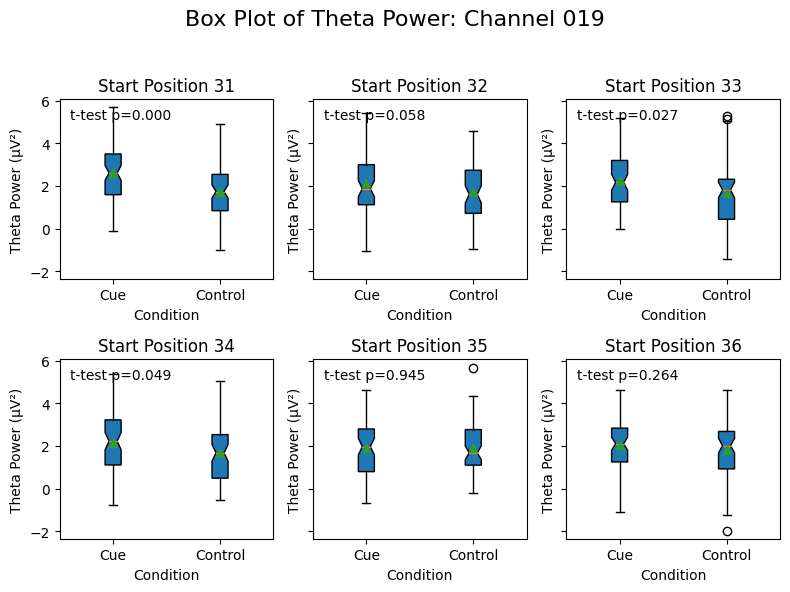

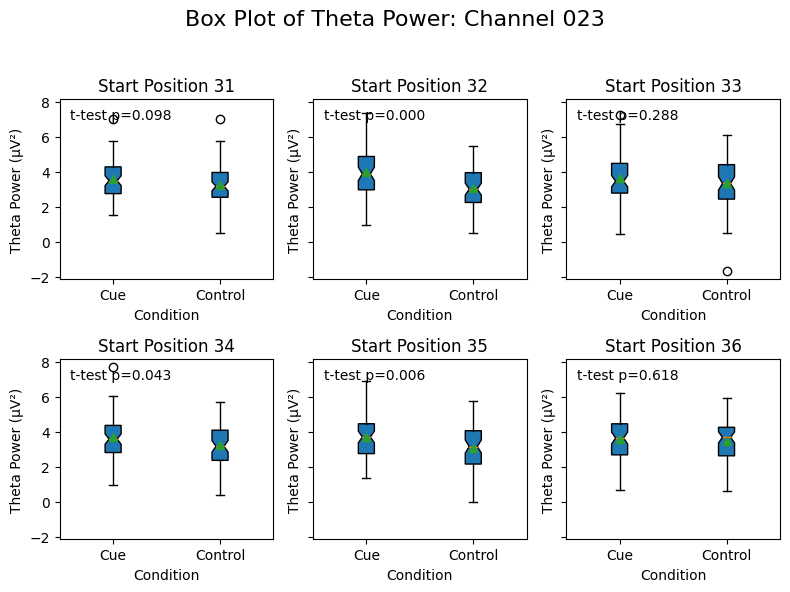

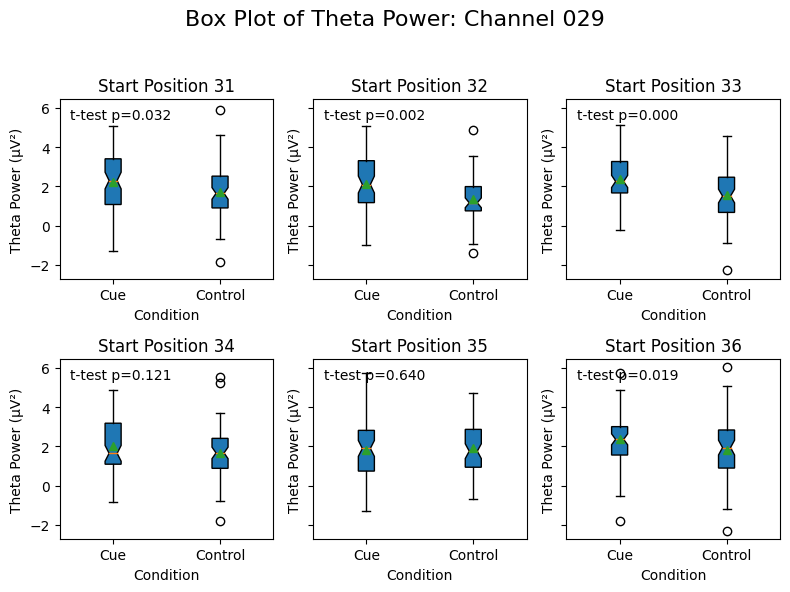

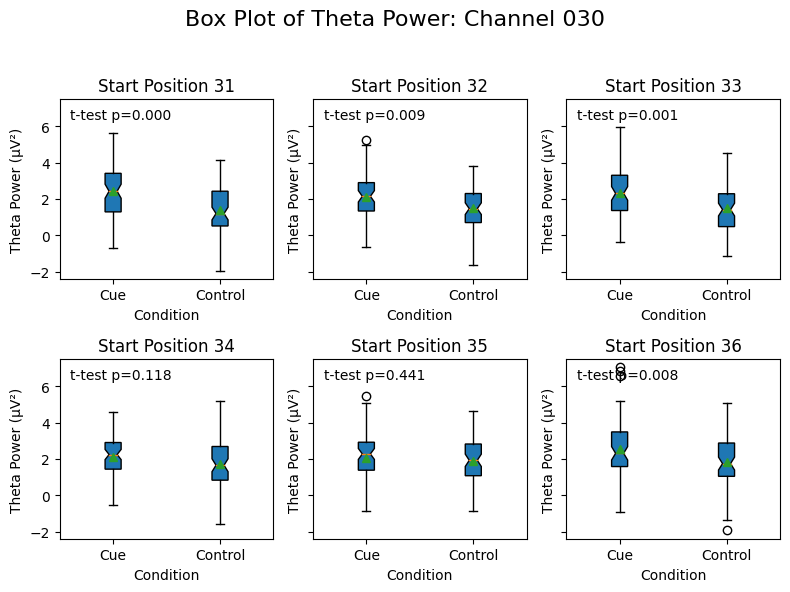

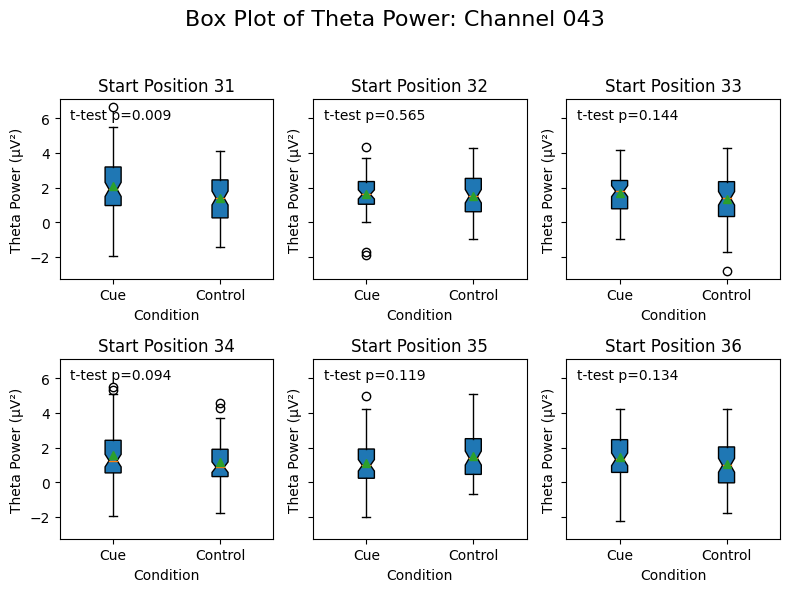

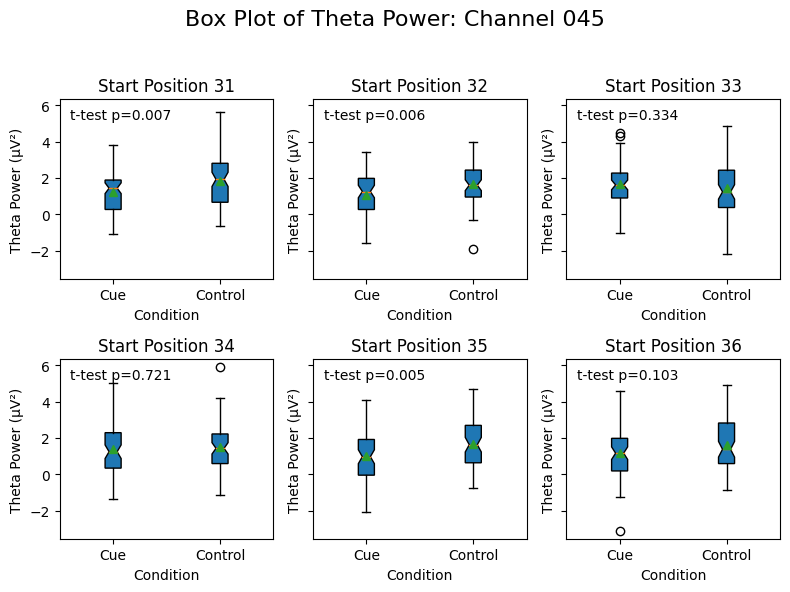

Combined Welch's t-test results saved to combined_ttest_theta_power.csv

Significant Welch's t-test Results:
    channel  start_position     test_type group1   group2    t_stat   p_value  \
0      019              31  Welch t-test    Cue  Control  3.877403  0.000159   
2      019              33  Welch t-test    Cue  Control  2.243095  0.026614   
3      019              34  Welch t-test    Cue  Control  1.987352  0.048978   
7      023              32  Welch t-test    Cue  Control  3.741606  0.000286   
9      023              34  Welch t-test    Cue  Control  2.042931  0.043053   
10     023              35  Welch t-test    Cue  Control  2.786525  0.006144   
12     029              31  Welch t-test    Cue  Control  2.167293  0.031862   
13     029              32  Welch t-test    Cue  Control  3.129206  0.002238   
14     029              33  Welch t-test    Cue  Control  3.715027  0.000302   
17     029              36  Welch t-test    Cue  Control  2.381302  0.018704   
18     030

In [59]:

# --- Prepare a list to hold all statistical test results ---
combined_results = []

# --- Plotting and Statistical Analysis Loop ---
for ch in ch_indx:
    channel_str = channel_no[ch]
    fig, axes = plt.subplots(2, 3, figsize=(8, 6), sharey=True)
    axes = axes.flatten()
    
    for i, start_position in enumerate(start_positions):
        ax = axes[i]
        # Filter cue and control data for the current channel and start position
        cue_data = cue_segments_df[(cue_segments_df['channel'] == channel_str) &
                                   (cue_segments_df['start_position'] == start_position)]
        control_data = control_segments_df[(control_segments_df['channel'] == channel_str) &
                                           (control_segments_df['start_position'] == start_position)]
        
        # --- Gather Theta Power Values for Each Group ---
        group_data = {}

        # Aggregate all cue trials into one list
        cue_trials = []
        if not cue_data.empty and 'cue_onset' in cue_data.columns:
            for onset in sorted(cue_data['cue_onset'].unique()):
                onset_data = cue_data[cue_data['cue_onset'] == onset]
                trials = compute_theta_trials(onset_data, key='flat_spec_og')
                if len(trials) > 0:
                    cue_trials.extend(trials)
        if cue_trials:
            group_data['Cue'] = cue_trials

        # For control: aggregate all trials
        control_trials = compute_theta_trials(control_data, key='flat_spec_og')
        if len(control_trials) > 0:
            group_data['Control'] = control_trials

        # --- Plot Box and Whisker Plot ---
        labels = list(group_data.keys())
        if labels:
            data = [group_data[label] for label in labels]
            ax.boxplot(data, labels=labels, patch_artist=True, notch=True, showmeans=True)
            ax.set_title(f'Start Position {start_position}')
            ax.set_xlabel('Condition')
            ax.set_ylabel('Theta Power (μV²)')
        
        # --- Perform Welch's t-test (independent samples t-test) ---
        if len(group_data) == 2:
            cue_values = np.array(group_data['Cue'])
            control_values = np.array(group_data['Control'])
            t_stat, p_value = ttest_ind(cue_values, control_values, equal_var=False)
            
            # Apply Bonferroni correction (only one test here, so it remains the same)
            adjusted_p_value = min(p_value * 1, 1.0)
            
            ax.text(0.05, 0.95, f't-test p={adjusted_p_value:.3f}', transform=ax.transAxes,
                    fontsize=10, verticalalignment='top')
            
            # Save the t-test result into our combined table
            combined_results.append({
                'channel': channel_str,
                'start_position': start_position,
                'test_type': 'Welch t-test',
                'group1': 'Cue',
                'group2': 'Control',
                't_stat': t_stat,
                'p_value': p_value,
                'p_adj': adjusted_p_value,
                'reject': adjusted_p_value < 0.05
            })
    
    plt.suptitle(f'Box Plot of Theta Power: Channel {channel_str}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Create a DataFrame from the combined results and save to CSV
results_df = pd.DataFrame(combined_results)
results_df.to_csv("combined_ttest_theta_power.csv", index=False)
print("Combined Welch's t-test results saved to combined_ttest_theta_power.csv")

# Optionally, display the table of significant comparisons
significant_results = results_df[results_df['reject'] == True]
print("\nSignificant Welch's t-test Results:\n", significant_results)


## Looking at the peak frequencies
### Start by first peak

In [60]:

# 1) Helper function to get first peak frequency
def compute_first_peak_freq(df, key='peak_freqs'):
    first_peaks = []
    for peak_list in df[key]:
        if isinstance(peak_list, (list, tuple, np.ndarray)) and len(peak_list) > 0:
            first_peaks.append(peak_list[0])
    return first_peaks

# 2) Directory to save figures
save_dir = "/Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/20181105/Control_Compare/Peak_Freqs_Fig"
os.makedirs(save_dir, exist_ok=True)

# 3) Prepare a list to hold statistical test results
combined_results = []

# 4) Main loop over channels
for ch in ch_indx:
    channel_str = channel_no[ch]
    
    # =======================================================================
    # A) Bar Charts for First Peak Frequency
    # =======================================================================
    fig_bar, axes_bar = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
    axes_bar = axes_bar.flatten()
    
    for i, start_position in enumerate(start_positions):
        ax = axes_bar[i]
        
        # Filter data
        cue_data = cue_segments_df[
            (cue_segments_df['channel'] == channel_str) &
            (cue_segments_df['start_position'] == start_position)
        ]
        control_data = control_segments_df[
            (control_segments_df['channel'] == channel_str) &
            (control_segments_df['start_position'] == start_position)
        ]
        
        # Gather first peak frequencies for each group
        group_data = {}
        
        # Cue: separate by each unique cue_onset
        if not cue_data.empty and 'cue_onset' in cue_data.columns:
            for onset in sorted(cue_data['cue_onset'].unique()):
                onset_data = cue_data[cue_data['cue_onset'] == onset]
                first_peaks = compute_first_peak_freq(onset_data, key='peak_freqs')
                if len(first_peaks) > 0:
                    group_data[f'Cue {onset}'] = first_peaks
        
        # Control: combine all control trials
        control_peaks = compute_first_peak_freq(control_data, key='peak_freqs')
        if len(control_peaks) > 0:
            group_data['Control'] = control_peaks
        
        labels = list(group_data.keys())
        if len(labels) > 1:
            # One-way ANOVA
            anova_data = [group_data[label] for label in labels]
            f_stat, p_val = f_oneway(*anova_data)
            
            # Bonferroni correction
            n_comparisons = len(labels) - 1
            adjusted_p_value = min(p_val * n_comparisons, 1.0)
            
            combined_results.append({
                'channel': channel_str,
                'start_position': start_position,
                'test_type': 'ANOVA (BarChart, First Peak)',
                'f_stat': f_stat,
                'p_value': p_val,
                'p_adj': adjusted_p_value,
                'reject': adjusted_p_value < 0.05
            })
            
            ax.text(0.05, 0.9, f'ANOVA p_adj={adjusted_p_value:.3f}',
                    transform=ax.transAxes, fontsize=9,
                    bbox=dict(facecolor='white', alpha=0.6))
        
        # Bar chart
        if labels:
            means = [np.mean(group_data[label]) for label in labels]
            sems = [sem(group_data[label]) for label in labels]
            x = np.arange(len(labels))
            ax.bar(x, means, yerr=sems, width=0.5, alpha=0.7, capsize=5, color='skyblue')
            ax.set_xticks(x)
            ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
        
        ax.set_title(f'Channel {channel_str} | Start Pos {start_position}', fontsize=10)
        ax.set_xlabel('Condition', fontsize=9)
        ax.set_ylabel('First Peak Freq (Hz)', fontsize=9)
    
    fig_bar.suptitle(f'First Peak Frequency - Bar Charts - Channel {channel_str}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    
    # Save the bar chart figure
    bar_fig_path = os.path.join(save_dir, f"Bar_FirstPeak_Channel_{channel_str}.png")
    fig_bar.savefig(bar_fig_path, dpi=300)
    plt.close(fig_bar)
    
    # =======================================================================
    # B) Heatmaps (Pairwise Tukey for First Peak Frequency)
    # =======================================================================
    fig_heat, axes_heat = plt.subplots(2, 3, figsize=(15, 10))
    axes_heat = axes_heat.flatten()
    im_for_colorbar = None
    
    for i, start_position in enumerate(start_positions):
        ax_heat = axes_heat[i]
        
        # Re-create group_data for the same channel & start position
        cue_data = cue_segments_df[
            (cue_segments_df['channel'] == channel_str) &
            (cue_segments_df['start_position'] == start_position)
        ]
        control_data = control_segments_df[
            (control_segments_df['channel'] == channel_str) &
            (control_segments_df['start_position'] == start_position)
        ]
        
        group_data = {}
        
        if not cue_data.empty and 'cue_onset' in cue_data.columns:
            for onset in sorted(cue_data['cue_onset'].unique()):
                onset_data = cue_data[cue_data['cue_onset'] == onset]
                first_peaks = compute_first_peak_freq(onset_data, key='peak_freqs')
                if len(first_peaks) > 0:
                    group_data[f'Cue {onset}'] = first_peaks
        
        control_peaks = compute_first_peak_freq(control_data, key='peak_freqs')
        if len(control_peaks) > 0:
            group_data['Control'] = control_peaks
        
        if len(group_data.keys()) > 1:
            # Build a long DataFrame for Tukey
            data_long = []
            for grp, freq_list in group_data.items():
                for val in freq_list:
                    data_long.append({'peak_freq': val, 'group': grp})
            df_long = pd.DataFrame(data_long)
            
            # Tukey HSD
            tukey_results = pg.pairwise_tukey(dv='peak_freq', between='group', data=df_long)
            
            # Build p-value matrix
            unique_groups = sorted(df_long['group'].unique())
            p_matrix = pd.DataFrame(np.ones((len(unique_groups), len(unique_groups))),
                                    index=unique_groups, columns=unique_groups)
            for _, row in tukey_results.iterrows():
                grp1 = row['A']
                grp2 = row['B']
                # Use whichever p-value column is present
                if 'p-corr' in tukey_results.columns:
                    p_val_corr = row['p-corr']
                elif 'p-tukey' in tukey_results.columns:
                    p_val_corr = row['p-tukey']
                else:
                    p_val_corr = row['p-unc']
                
                p_matrix.loc[grp1, grp2] = p_val_corr
                p_matrix.loc[grp2, grp1] = p_val_corr
            
            im = ax_heat.matshow(p_matrix, cmap='viridis', vmin=0, vmax=1)
            if im_for_colorbar is None:
                im_for_colorbar = im
            
            ax_heat.set_xticks(np.arange(len(unique_groups)))
            ax_heat.set_yticks(np.arange(len(unique_groups)))
            ax_heat.set_xticklabels(unique_groups, rotation=45, ha='left', fontsize=8)
            ax_heat.set_yticklabels(unique_groups, fontsize=8)
            ax_heat.set_title(f'Start Pos {start_position}', fontsize=10)
            
            # Annotate each cell with p-value
            for (m, n), val in np.ndenumerate(p_matrix.values):
                text_color = 'white' if val < 0.5 else 'black'
                ax_heat.text(n, m, f'{val:.3f}', ha='center', va='center', color=text_color, fontsize=8)
        else:
            ax_heat.text(0.5, 0.5, "Not enough\ndata", ha='center', va='center', fontsize=12)
            ax_heat.axis('off')
    
    fig_heat.suptitle(f'Tukey HSD p-values (First Peak) - Channel {channel_str}', fontsize=14)
    if im_for_colorbar is not None:
        fig_heat.colorbar(im_for_colorbar, ax=axes_heat.ravel().tolist(),
                          shrink=0.6, label='Corrected p-value')
    
    # Save the heatmap figure
    heatmap_fig_path = os.path.join(save_dir, f"Heatmap_FirstPeak_Channel_{channel_str}.png")
    fig_heat.savefig(heatmap_fig_path, dpi=300)
    plt.close(fig_heat)
    
    # =======================================================================
    # C) Violin Plots (with Significance Markers for First Peak Frequency)
    # =======================================================================
    fig_violin, axes_violin = plt.subplots(2, 3, figsize=(20, 15), sharey=True)
    axes_violin = axes_violin.flatten()
    
    for i, start_position in enumerate(start_positions):
        ax = axes_violin[i]
        
        # Filter data
        cue_data = cue_segments_df[
            (cue_segments_df['channel'] == channel_str) &
            (cue_segments_df['start_position'] == start_position)
        ]
        control_data = control_segments_df[
            (control_segments_df['channel'] == channel_str) &
            (control_segments_df['start_position'] == start_position)
        ]
        
        group_data = {}
        
        if not cue_data.empty and 'cue_onset' in cue_data.columns:
            for onset in sorted(cue_data['cue_onset'].unique()):
                onset_data = cue_data[cue_data['cue_onset'] == onset]
                first_peaks = compute_first_peak_freq(onset_data, key='peak_freqs')
                if len(first_peaks) > 0:
                    group_data[f'Cue {onset}'] = first_peaks
        
        control_peaks = compute_first_peak_freq(control_data, key='peak_freqs')
        if len(control_peaks) > 0:
            group_data['Control'] = control_peaks
        
        labels = list(group_data.keys())
        if len(labels) > 1:
            # One-way ANOVA
            anova_data = [group_data[label] for label in labels]
            f_stat, p_val = f_oneway(*anova_data)
            
            # Bonferroni correction
            n_comparisons = len(labels) - 1
            adjusted_p_value = min(p_val * n_comparisons, 1.0)
            
            combined_results.append({
                'channel': channel_str,
                'start_position': start_position,
                'test_type': 'ANOVA (Violin, First Peak)',
                'f_stat': f_stat,
                'p_value': p_val,
                'p_adj': adjusted_p_value,
                'reject': adjusted_p_value < 0.05
            })
            
            ax.text(0.05, 0.9, f'ANOVA p_adj={adjusted_p_value:.3f}',
                    transform=ax.transAxes, fontsize=9,
                    bbox=dict(facecolor='white', alpha=0.6))
        
        # Violin plot
        if labels:
            # Sort any 'Cue X' labels numerically
            cue_labels = [k for k in labels if k.startswith('Cue')]
            cue_labels_sorted = sorted(cue_labels, key=lambda x: float(x.split()[1]))
            final_labels = cue_labels_sorted + ([k for k in labels if k == 'Control'] if 'Control' in labels else [])
            
            data_list = [group_data[label] for label in final_labels]
            positions = np.arange(len(final_labels))
            
            vp = ax.violinplot(data_list, positions=positions, showmedians=True, widths=0.7, showextrema=False)
            ax.set_xticks(positions)
            ax.set_xticklabels(final_labels, rotation=45, ha='right', fontsize=9)
            
            # Overlay individual data points
            for pos, label in zip(positions, final_labels):
                y_data = group_data[label]
                x_jitter = pos + 0.05 * np.random.randn(len(y_data))
                ax.scatter(x_jitter, y_data, color='black', s=10, alpha=0.5)
            
            # Post Hoc & Significance
            data_long = []
            for grp in final_labels:
                for val in group_data[grp]:
                    data_long.append({'peak_freq': val, 'group': grp})
            df_long = pd.DataFrame(data_long)
            
            tukey_results = pg.pairwise_tukey(dv='peak_freq', between='group', data=df_long)
            
            # Helper to get the correct p-value
            def get_p_val(row):
                if 'p-corr' in row:
                    return row['p-corr']
                elif 'p-tukey' in row:
                    return row['p-tukey']
                else:
                    return row['p-unc']
            
            all_vals = np.concatenate(data_list)
            global_max = np.max(all_vals)
            global_min = np.min(all_vals)
            y_range = global_max - global_min
            offset_val = y_range * 0.1
            
            significance_offsets = {}
            for _, row in tukey_results.iterrows():
                p_val_signif = get_p_val(row)
                if p_val_signif < 0.05:
                    grp1 = row['A']
                    grp2 = row['B']
                    if grp1 in final_labels and grp2 in final_labels:
                        i1 = final_labels.index(grp1)
                        i2 = final_labels.index(grp2)
                        base_level = max(np.max(group_data[grp1]), np.max(group_data[grp2]))
                        key = (min(i1, i2), max(i1, i2))
                        extra_offset = significance_offsets.get(key, 0)
                        y_level = base_level + offset_val + extra_offset
                        significance_offsets[key] = extra_offset + offset_val * 0.5
                        
                        # Draw significance bar
                        x1, x2 = i1, i2
                        ax.plot([x1, x1, x2, x2],
                                [y_level - offset_val * 0.2, y_level, y_level, y_level - offset_val * 0.2],
                                lw=1.5, c='black')
                        ax.text((x1 + x2) / 2, y_level, "*", ha='center', va='bottom',
                                color='black', fontsize=12)
        
        ax.set_title(f'Channel {channel_str} | Start Pos {start_position}', fontsize=10)
        ax.set_xlabel('Condition', fontsize=9)
        ax.set_ylabel('First Peak Freq (Hz)', fontsize=9)
    
    fig_violin.suptitle(f'Violin Plot of First Peak Frequency - Channel {channel_str}', fontsize=14)
    plt.tight_layout()
    
    # Save the violin figure
    violin_fig_path = os.path.join(save_dir, f"Violin_FirstPeak_Channel_{channel_str}.png")
    fig_violin.savefig(violin_fig_path, dpi=300)
    plt.close(fig_violin)

# -------------------------------------------------------------------------
# 5) Save combined ANOVA results to CSV
results_df = pd.DataFrame(combined_results)
csv_path = os.path.join(save_dir, "combined_anova_bonferroni_first_peak.csv")
results_df.to_csv(csv_path, index=False)
print(f"Combined ANOVA results (with Bonferroni correction) saved to {csv_path}")

# 6) Optionally, display significant comparisons
significant_results = results_df[results_df['reject'] == True]
print("\nSignificant Comparisons (First Peak Frequency):\n", significant_results)


Combined ANOVA results (with Bonferroni correction) saved to /Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/20181105/test/combined_anova_bonferroni_first_peak.csv

Significant Comparisons (First Peak Frequency):
    channel  start_position                     test_type    f_stat   p_value  \
12     023              31  ANOVA (BarChart, First Peak)  5.962337  0.000058   
14     023              33  ANOVA (BarChart, First Peak)  6.418541  0.000030   
15     023              34  ANOVA (BarChart, First Peak)  3.616048  0.004624   
16     023              35  ANOVA (BarChart, First Peak)  4.649055  0.000719   
17     023              36  ANOVA (BarChart, First Peak)  6.402088  0.000029   
18     023              31    ANOVA (Violin, First Peak)  5.962337  0.000058   
20     023              33    ANOVA (Violin, First Peak)  6.418541  0.000030   
21     023              34    ANOVA (Violin, First Peak)  3.616048  0.004624   
22     023              35    ANOVA (Violin, Fi

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- Helper function to compute detection probability for a given peak order ---
def compute_peak_detection(df, peak_idx=1, key='peak_freqs'):
    """
    Returns the proportion of trials (rows) in the DataFrame df 
    where the length of the list in column 'peak_freqs' is at least peak_idx.
    """
    if df.empty:
        return np.nan
    # Create a binary indicator: 1 if at least peak_idx peaks exist, else 0
    indicator = df[key].apply(lambda x: 1 if isinstance(x, (list, tuple, np.ndarray)) and len(x) >= peak_idx else 0)
    return indicator.mean()

# --- Directory for saving figures ---
save_dir = "/Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/20181105"
os.makedirs(save_dir, exist_ok=True)

# --- Loop over channels ---
for ch in ch_indx:
    channel_str = channel_no[ch]
    
    # --- Create a figure for detection probabilities (grouped bar plots) ---
    # We'll create one subplot per start position (assumed to be 6 in a 2x3 grid)
    fig_prob, axes_prob = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
    axes_prob = axes_prob.flatten()
    
    for i, start_position in enumerate(start_positions):
        ax = axes_prob[i]
        
        # Filter data for the current channel and start position
        cue_data = cue_segments_df[
            (cue_segments_df['channel'] == channel_str) &
            (cue_segments_df['start_position'] == start_position)
        ]
        control_data = control_segments_df[
            (control_segments_df['channel'] == channel_str) &
            (control_segments_df['start_position'] == start_position)
        ]
        
        # Build a dictionary that holds, for each condition, the detection probabilities for peak 1, 2, and 3
        detection_probs = {}
        
        # For cue conditions: separate by each unique cue onset
        if not cue_data.empty and 'cue_onset' in cue_data.columns:
            for onset in sorted(cue_data['cue_onset'].unique()):
                sub_df = cue_data[cue_data['cue_onset'] == onset]
                p1 = compute_peak_detection(sub_df, peak_idx=1, key='peak_freqs')
                p2 = compute_peak_detection(sub_df, peak_idx=2, key='peak_freqs')
                p3 = compute_peak_detection(sub_df, peak_idx=3, key='peak_freqs')
                detection_probs[f'Cue {onset}'] = [p1, p2, p3]
        
        # For control condition
        if not control_data.empty:
            p1 = compute_peak_detection(control_data, peak_idx=1, key='peak_freqs')
            p2 = compute_peak_detection(control_data, peak_idx=2, key='peak_freqs')
            p3 = compute_peak_detection(control_data, peak_idx=3, key='peak_freqs')
            detection_probs['Control'] = [p1, p2, p3]
        
        # If no conditions are present, skip plotting for this start position
        if not detection_probs:
            ax.text(0.5, 0.5, "No Data", ha='center', va='center', fontsize=12)
            ax.axis('off')
            continue
        
        # Create a grouped bar plot:
        conditions = list(detection_probs.keys())
        n_conditions = len(conditions)
        x = np.arange(n_conditions)  # one tick per condition
        peak_orders = [1, 2, 3]
        n_peaks = len(peak_orders)
        bar_width = 0.2
        
        # For each peak order, plot a set of bars with an offset
        offsets = np.linspace(-bar_width, bar_width, n_peaks)
        for idx, peak in enumerate(peak_orders):
            # Get the detection probability for each condition for the given peak
            vals = [detection_probs[cond][idx] for cond in conditions]
            ax.bar(x + offsets[idx], vals, width=bar_width, label=f'Peak {peak}')
        
        ax.set_xticks(x)
        ax.set_xticklabels(conditions, rotation=45, ha='right', fontsize=9)
        ax.set_ylim(0, 1)
        ax.set_ylabel('Detection Probability')
        ax.set_title(f'Start Pos {start_position}', fontsize=10)
        ax.legend(fontsize=8)
    
    fig_prob.suptitle(f'Peak Detection Probabilities - Channel {channel_str}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    
    # Save the probability figure
    prob_fig_path = os.path.join(save_dir, f"PeakDetectionProb_Channel_{channel_str}.png")
    fig_prob.savefig(prob_fig_path, dpi=300)
    plt.close(fig_prob)


NameError: name 'day' is not defined